In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns


Read the data
===========

In [4]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


x_original['max']=np.min(x_original[['FIELD_6','FIELD_7']],axis=1)
x_original=x_original.drop(columns=['FIELD_6','FIELD_7'])
x_original=x_original.query('FIELD_16 != 1 and FIELD_23 != 1')

y_original['max']=np.min(y_original[['FIELD_6','FIELD_7']],axis=1)
y_original=y_original.drop(columns=['FIELD_6','FIELD_7'])
y_original=y_original.query('FIELD_16 != 1 and FIELD_23 != 1')



In [12]:

x=x_original[['Unnamed: 0','S000300', 'S000501', 'L103300', 'L100700', 'L190400', 'L103000', 'L103100', 
              'L100800', 'L101700', 'L101300', 'FIELD_41', 'S000502', 'FIELD_33', 'L100500', 'FIELD_40', 'FIELD_31',
              
             'FIELD_15','FIELD_17','FIELD_22','FIELD_24','FIELD_16','FIELD_23','AGE','SEX']]

y=y_original[['Unnamed: 0','S000300']]

print(x_original.shape)
print(y_original.shape)

(159381, 407)
(159381, 407)


Prepare the data
============

In [13]:
data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.query('FIELD_15 !=1 and FIELD_17 !=1 and FIELD_22 != 1 and FIELD_24 != 1 and FIELD_16 != 1 and FIELD_23 != 1')

# data=data[data.SEX==0]
# data=data[data.AGE>=40]
data=data.dropna(). reset_index()

# data=data[data.FIELD_15!=1]
# data=data[data.FIELD_17!=1]
# data=data[data.FIELD_22!=1]
# data=data[data.FIELD_24!=1]

# data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
# data=data.drop(columns=['FIELD_6','FIELD_7'])
# data=data.query('FIELD_16 != 1 and FIELD_23 != 1')


print(data.shape)
data.head()

(128085, 27)


,index,Unnamed: 0,S000300_x,S000501,L103300,L100700,L190400,L103000,L103100,L100800,...,FIELD_31,FIELD_15,FIELD_17,FIELD_22,FIELD_24,FIELD_16,FIELD_23,AGE,SEX,S000300_y
0,0,0,20.1,121.0,3.1,3.0,12.3,53.0,68.0,77.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,19.7
1,1,1,19.7,117.0,3.3,3.0,13.1,53.0,71.0,89.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,1.0,20.2
2,2,2,20.2,135.0,3.4,3.8,12.9,41.0,72.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,1.0,21.0
3,3,3,24.8,118.0,2.8,3.7,13.5,58.0,64.0,95.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,25.5
4,4,4,25.5,111.0,2.9,3.4,12.6,50.0,58.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,25.4


Check the correlation of the selected feature with the independent variables
=====

In [15]:
temppd=pd.DataFrame(data.copy()[['S000300_x', 'S000501', 'L103300', 'L100700', 'L190400', 'L103000', 'L103100', 'L100800',
                                 'L101700', 'L101300', 'FIELD_41', 'S000502', 'FIELD_33', 'L100500', 'FIELD_40', 
                                 'FIELD_31'
                                ]]).dropna() 
temppd['y']=data.S000300_y
temppd.corr().head(20)
# corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1)

# # mask = np.zeros_like(corr)
# # mask[np.triu_indices_from(mask)] = True
# # with sns.axes_style("white"):
# #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

# corr.head(20)

,S000300_x,S000501,L103300,L100700,L190400,L103000,L103100,L100800,L101700,L101300,FIELD_41,S000502,FIELD_33,L100500,FIELD_40,FIELD_31,y
S000300_x,1.000000,0.449543,0.470509,0.430565,0.369989,0.369558,-0.399307,0.312507,0.282480,0.373518,0.058727,0.365886,0.257143,0.313870,0.091047,0.028742,0.884148
S000501,0.449543,1.000000,0.282800,0.340971,0.372282,0.277802,-0.205430,0.284608,0.257910,0.244497,0.063376,0.765555,0.204483,0.280253,0.087347,-0.003287,0.407668
L103300,0.470509,0.282800,1.000000,0.409529,0.380240,0.611733,-0.743673,0.295308,0.260800,0.326575,-0.018840,0.261268,0.287979,0.320223,-0.007930,0.026141,0.422182
L100700,0.430565,0.340971,0.409529,1.000000,0.552634,0.366911,-0.323835,0.206300,0.325832,0.335970,0.042326,0.304959,0.371602,0.557643,0.080141,0.002609,0.401143
L190400,0.369989,0.372282,0.380240,0.552634,1.000000,0.320894,-0.306561,0.243169,0.310583,0.334807,0.033690,0.340510,0.464803,0.559423,0.075084,-0.015617,0.348863
L103000,0.369558,0.277802,0.611733,0.366911,0.320894,1.000000,-0.425593,0.372405,0.385309,0.290415,-0.036096,0.269777,0.298065,0.231949,-0.021952,0.016261,0.324684
L103100,-0.399307,-0.205430,-0.743673,-0.323835,-0.306561,-0.425593,1.000000,-0.197411,-0.142229,-0.226382,0.033245,-0.170192,-0.261023,-0.270435,0.020072,-0.019592,-0.357972
L100800,0.312507,0.284608,0.295308,0.206300,0.243169,0.372405,-0.197411,1.000000,0.255252,0.193508,0.032413,0.263179,0.181967,0.189352,0.049653,0.033984,0.271970
L101700,0.282480,0.257910,0.260800,0.325832,0.310583,0.385309,-0.142229,0.255252,1.000000,0.469109,0.001804,0.254874,0.283500,0.210397,0.017409,0.008339,0.255672
L101300,0.373518,0.244497,0.326575,0.335970,0.334807,0.290415,-0.226382,0.193508,0.469109,1.000000,-0.005542,0.222178,0.199261,0.224092,0.008078,0.013164,0.337086


In [17]:
y=data[['S000300_y']]

x=data[['S000300_x', 'S000501', 'L103300', 'L100700', 'L190400', 'L103000', 'L103100', 'L100800',
                                 'L101700', 'L101300', 'FIELD_41', 'S000502', 'FIELD_33', 'L100500', 'FIELD_40', 
                                 'FIELD_31']]


Apply PCA
===========

In [18]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [19]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [20]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [21]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [24]:
ylable=y[['S000300_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [25]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[9.24420224e-01 2.17001258e-03 7.75097765e-05 1.95980173e-02
 2.88072584e-04 2.19894385e-04 8.81000144e-05 5.23691151e-03
 1.41940375e-02 3.62822266e-03 1.75181609e-05 2.67344679e-02
 1.11575393e-05 3.25442112e-03 5.82306376e-05 3.20287309e-06]


mean_squared_error 1.594244656355954
root mean_squared_error 1.2626340152062885
mean_absolute_error 0.6845329743567139
r2_score 0.8579335353133977


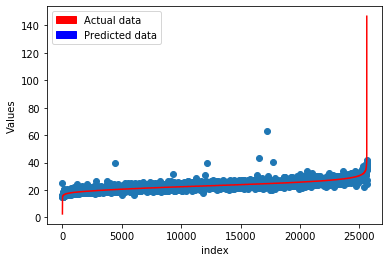

,t + 1,pred (t +1)
9084,40.3,39.305937
24963,40.4,38.684732
4209,40.5,38.477700
19745,41.1,34.764586
17950,42.0,37.889915
22975,42.2,39.566730
9116,45.4,41.418141
23226,46.8,38.507364
20820,66.2,24.184419
3192,146.6,27.340974


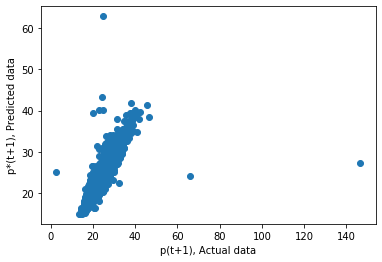

In [26]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

xg boost
==========

In [27]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [28]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 1.7718282405656436
root mean_squared_error 1.3311003871104703
mean_absolute_error 0.7872640715618157
r2_score 0.8421086919341433


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)